<a href="https://colab.research.google.com/github/helmana/DLeeg/blob/master/model%20layers%20pop/model3_1%20layer%20pop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
subject number = 109 >> 90 train subject  + 19 new subject 
channel number = 20 >> [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]

model3 -  1 layer pop

** subjects  (train subject (ts) , new subject (ns) ):

1) Train subject i (ts[i] )
2) Train Subject i and Train Subject j (ts[i] , ts[j] )
3) Train subject and New subject  (ts , ns)
4) New subject i ( ns[i] )
5) New Subject i and New Subject j (ns[i] , ns[j] )

'''


'\n109 subject\n1 channel (Oz)\ntask: REO \nepoch: 60\nseed = 14\n\nTrainResult ([loss , acc])= [0.12535213132612147, 0.959957998996991]\nValidationResult ([loss , acc])= [0.1946041866179451, 0.9351468373493976]\nTestResult ([loss , acc])= [0.20246034180243572, 0.9319486027944112]\n\n'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install mne

In [0]:
'''
Rivision:
980806:
  First version.
  
  

'''

'\nRivision:\n980806:\n  First version.\n  \n  \n\n'

In [0]:
# Parameters:

EpochNum=60
subject_numberT=109
RemoveBaseLine=0
Orthogonal=1
task_index = [1] # task: REO
list_channel=[21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
TryStr='Try1'
seed = 14

task_number=1
task_time = 60
sampel_number_per_sec =  160 # sampel rate
total_sampel_number =  sampel_number_per_sec *task_time # 60*160
#sample_shift = 4 #step len
inner_sample_shift = 4 # inner step len
outer_sample_shift =8  # outer step len
window_len= 20
batch_size=64

#Search_Space_Channel = [21,23,29,31,33,35,36,40,8,10,12,41,46,48,50,52,54,60,61,62]
#Search_Space_Channel_Name=["Fp1","Fp2","F7","F3","Fz","F4","F8","T7","C3","Cz","C4","T8","P7","P3","Pz","P4","P8","O1","Oz","O2"]


In [0]:
# For Visualization
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

# General use
import itertools
from itertools import combinations 

import os.path
from scipy.spatial import distance
import numpy as np
import math
import random
import datetime
import time
import pytz
from time import gmtime, strftime

# For model training
from keras import layers
from keras import models
from keras import regularizers
from keras.utils import to_categorical
from keras import optimizers
from keras import backend as KerasBackend
from keras.models import load_model



# EEG Tools
import mne
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
from mne import io
from mne import viz
from mne import Epochs, io, pick_types
from mne.event import define_target_events
from mne.time_frequency import psd_welch
print(__doc__)



Automatically created module for IPython interactive environment


In [0]:
# load dataset in array
task_number= len(task_index)

# load dataset in array
list_raw_fnames = [[0]*task_number]*subject_numberT
for x in range(subject_numberT):
  list_raw_fnames[x] = mne.datasets.eegbci.load_data(x+1,task_index,path='/content/drive/My Drive/Deep Results/Database')

list_rawdata = np.zeros((subject_numberT,task_number), dtype='object')

for i in range(subject_numberT):
  for j in range(task_number):
    list_rawdata[i][j] = mne.io.read_raw_edf(list_raw_fnames[i][j], preload=True)


Do you want to set the path:
    /content/drive/My Drive/Deep Results/Database
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /content/drive/My Drive/Deep Results/Database/MNE-eegbci-data/physiobank/database/eegmmidb/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.in

In [0]:
subject_number = 90
# new subject
new_subject =np.arange(subject_number, subject_numberT)

# img for each subject
subject_img_number = math.floor((total_sampel_number - sampel_number_per_sec - (window_len-1 )*inner_sample_shift) / outer_sample_shift) +1
np.random.seed(seed)  

subject_number_array_shuffled=np.arange(subject_number)
np.random.shuffle(subject_number_array_shuffled)

subject_img_number_array_shuffled=np.arange(subject_img_number)
np.random.shuffle(subject_img_number_array_shuffled)

train_index = len(subject_img_number_array_shuffled)//2
val_index = train_index + len(subject_img_number_array_shuffled)//4

train_shuff = subject_img_number_array_shuffled[:train_index]
val_shuff = subject_img_number_array_shuffled[train_index:val_index]
test_shuff = subject_img_number_array_shuffled[val_index:]


train_number = len(train_shuff)
val_number = len(val_shuff)
test_number = len(test_shuff)


In [0]:
def normalize_channel_data(ch , i, ch_min, ch_max):
  ch = ((ch - ch_min[i]) / (ch_max[i] - ch_min[i] ))
  return ch

def ProjectionVector(VecA,VecB):
    Projeted_VecB_on_VecA=np.dot(VecA,VecB)/np.dot(VecA,VecA)*VecA
    return Projeted_VecB_on_VecA

In [0]:
#################################################################################################
## Define General Data Generator
def GenerateGeneralData(BatchSize,ListRawDataMain,SubjectArrayShuffled,ListChannel,RemoveBaseLineFlag,OrthogonalFlag,ImageArrayShuffled,WindowLen,OuterSampleShift,InnerSampleShift,SampelNumberPerSec):
    
    Iter=0
    #ch_number=len(ListChannel)
    
    
    ##########################################################
    # Pre-Proceesing On Raw Data
    ListRawDataTemp=ListRawDataMain.copy()
    
    DataAllChannelsRawPerSubject, times =(ListRawDataTemp[0][0][:64,:9600])

    DataChannelsRaw   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsNormal=np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    DataChannelsOrt   =np.zeros((len(SubjectArrayShuffled),ch_number,times.size),dtype = float)
    e= 0    
    for s in SubjectArrayShuffled:

        DataAllChannelsRawPerSubject, times =(ListRawDataTemp[s][0][:64,:9600])
        
        # Extrac Channel T9 or T10 as Baseline
        DataChannelT9Raw =DataAllChannelsRawPerSubject[43]# Ch T9 (42) or T10 (43)


        ch_max =[]
        ch_min =[]
        # Extract Selected Channels+ Remove Baseline+ Normailze
        
        for i in range(len(ListChannel)):
            DataChannelsRaw[e][i]=DataAllChannelsRawPerSubject[ListChannel[i]].copy() -DataChannelT9Raw*RemoveBaseLineFlag

            ch_max = np.append(ch_max, max(DataChannelsRaw[e][i])) # max for each cannel
            ch_min = np.append(ch_min, min(DataChannelsRaw[e][i])) # min for each cannel

            DataChannelsNormal[e][i]=normalize_channel_data(DataChannelsRaw[e][i].copy(), i, ch_min, ch_max)
        e = e+1

        # Orthogonal Channel
        #DataChannelsOrt[e][0]=DataChannelsNormal[e][0]
        #DataChannelsOrt[e][1]=DataChannelsNormal[e][1]-ProjectionVector(DataChannelsNormal[e][0].copy(),DataChannelsNormal[e][1].copy())*OrthogonalFlag
        
        
        
    ##########################################################
    # Generate Data for Network
    while True:

      for j in ImageArrayShuffled:
          r = 0
          for s in SubjectArrayShuffled:

              if Iter ==0:
                  TrainImage=np.zeros((BatchSize, ch_number, WindowLen, SampelNumberPerSec), dtype = float)
                  TrainLabel=np.zeros((BatchSize),dtype=int)

              for i in range(len(ListChannel)):
                  for z in range (WindowLen):
                      ExtractedData = DataChannelsNormal[r][i][0+j*OuterSampleShift + z*InnerSampleShift:SampelNumberPerSec+ j*OuterSampleShift + z*InnerSampleShift]
                      TrainImage[Iter][i][z] = ExtractedData.copy()# Data
              r=r+1

              TrainLabel[Iter] = s # label

              Iter=Iter+1
              #Count=Count+1
              if Iter==BatchSize:
                Iter=0
                #print('Count=',Count)
                TrainLabelClass=to_categorical(TrainLabel,subject_numberT)
                TI = np.moveaxis(TrainImage, 1, -1)
                yield TI, TrainLabelClass 

                

In [0]:
ch_number=len(list_channel)
list_rawdataTemp=list_rawdata.copy()


Epoch 1/100
823/823 [==============================] - 20s 25ms/step - loss: 4.3284 - acc: 0.0416 - val_loss: 3.8304 - val_acc: 0.0832
Epoch 2/100
823/823 [==============================] - 19s 24ms/step - loss: 3.5285 - acc: 0.1175 - val_loss: 2.9775 - val_acc: 0.2273
Epoch 3/100
823/823 [==============================] - 19s 24ms/step - loss: 2.9474 - acc: 0.2065 - val_loss: 2.5694 - val_acc: 0.2920
Epoch 4/100
823/823 [==============================] - 20s 24ms/step - loss: 2.5640 - acc: 0.2835 - val_loss: 2.9098 - val_acc: 0.2057
Epoch 5/100
823/823 [==============================] - 20s 24ms/step - loss: 2.2451 - acc: 0.3557 - val_loss: 1.9266 - val_acc: 0.4573
Epoch 6/100
823/823 [==============================] - 20s 24ms/step - loss: 1.9807 - acc: 0.4175 - val_loss: 1.7362 - val_acc: 0.4634
Epoch 7/100
823/823 [==============================] - 20s 24ms/step - loss: 1.7849 - acc: 0.4589 - val_loss: 1.3714 - val_acc: 0.5928
Epoch 8/100
823/823 [==============================] - 

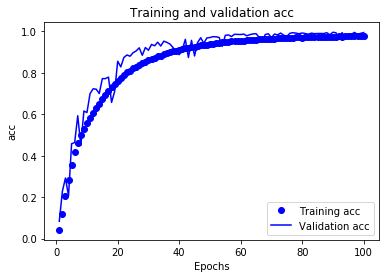

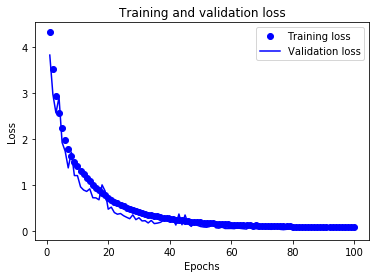

In [0]:
# Construct Data Generator

GenTrainData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled=subject_number_array_shuffled,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled=train_shuff)

GenValidationData =GenerateGeneralData(BatchSize=batch_size,
                                        ListRawDataMain=list_rawdataTemp.copy(),
                                        SubjectArrayShuffled=subject_number_array_shuffled,
                                        ListChannel=list_channel,
                                        RemoveBaseLineFlag=RemoveBaseLine,
                                        OrthogonalFlag=Orthogonal,
                                        WindowLen=window_len,
                                        OuterSampleShift=outer_sample_shift,
                                        InnerSampleShift=inner_sample_shift,
                                        SampelNumberPerSec=sampel_number_per_sec,
                                        ImageArrayShuffled=val_shuff)

GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                ListRawDataMain=list_rawdataTemp.copy(),
                                SubjectArrayShuffled=subject_number_array_shuffled,
                                ListChannel=list_channel,
                                RemoveBaseLineFlag=RemoveBaseLine,
                                OrthogonalFlag=Orthogonal,
                                WindowLen=window_len,
                                OuterSampleShift=outer_sample_shift,
                                InnerSampleShift=inner_sample_shift,
                                SampelNumberPerSec=sampel_number_per_sec,
                                ImageArrayShuffled=test_shuff)

#################################################################################################
# Create Model
model = models.Sequential()
model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape = (window_len,160,ch_number) ))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(subject_numberT, activation = 'softmax'))

model.compile(loss= 'categorical_crossentropy',
              optimizer= optimizers.RMSprop(lr= 1e-4),
              metrics = ['acc'])

#################################################################################################
# Train the Model
history = model.fit_generator(epochs =100,
                              generator=GenTrainData,
                              steps_per_epoch=np.ceil(train_number*subject_number/batch_size),
                              validation_data=GenValidationData,
                              validation_steps =np.ceil(val_number*subject_number/batch_size),
                              use_multiprocessing=False,
                              workers=1)

#################################################################################################
# Evalute the Model
TrainResult      =model.evaluate_generator(GenTrainData,steps=np.ceil(train_number*subject_number/batch_size))
ValidationResult =model.evaluate_generator(GenValidationData,steps=np.ceil(val_number*subject_number/batch_size))
TestResult       =model.evaluate_generator(GenTestData,steps=np.ceil(test_number*subject_number/batch_size))
print('     TrainResult ([loss , acc])=',TrainResult)
print('ValidationResult ([loss , acc])=',ValidationResult)
print('      TestResult ([loss , acc])=',TestResult)

#################################################################################################
# plot accuracy
history_dict = history.history 
acc_values = history_dict ['acc'] 
val_acc_values = history_dict['val_acc']
epochs = range(1, len(acc_values) + 1)


#plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training acc') 
plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
plt.title('Training and validation acc') 
plt.xlabel('Epochs') 
plt.ylabel('acc') 
plt.legend()
plt.show()

history_dict = history.history 
loss_values = history_dict ['loss'] 
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss') 
plt.plot(epochs, val_loss_values, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend()
plt.show()

In [0]:
#model.save('/content/drive/My Drive/mymodels/model1.h5')

In [0]:
model = load_model('/content/drive/My Drive/mymodels/model1.h5')
model.summary()
model.pop()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 160, 64)       1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 80, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 78, 128)        73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 39, 128)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 37, 256)        295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 18, 256)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)             

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
def subject_Predict_generator(mymodel, subject_arr, img_arr ):
  sn = len(subject_arr)
  imgn = len(img_arr)
  pre_GenTestData=GenerateGeneralData(BatchSize=batch_size,
                                  ListRawDataMain=list_rawdataTemp.copy(),
                                  SubjectArrayShuffled= subject_arr,
                                  ListChannel=list_channel,
                                  RemoveBaseLineFlag=RemoveBaseLine,
                                  OrthogonalFlag=Orthogonal,
                                  WindowLen=window_len,
                                  OuterSampleShift=outer_sample_shift,
                                  InnerSampleShift=inner_sample_shift,
                                  SampelNumberPerSec=sampel_number_per_sec,
                                  ImageArrayShuffled= img_arr)

  pre_Subject = mymodel.predict_generator(pre_GenTestData,steps=np.ceil(imgn*sn/batch_size))
  return pre_Subject


In [0]:
'''
**  subjects  (train subject (ts) , new subject (ns) ):

1) Train subject i (ts[i] )
2) Train Subject i and Train Subject j (ts[i] , ts[j] )
3) Train subject and New subject  (ts , ns)
4) New subject i ( ns[i] )
5) New Subject i and New Subject j (ns[i] , ns[j] )

'''

'\n* train subject (ts) , new subject (ns) :\n1) ts[i] , ts[i] \n2) ts[i] , ts[j]\n3) ts , ns\n4) ns[i] , ns[i]\n5) ns[i] , ns[j]\n\n'

In [0]:
## 1) Train subject i (ts[i] )
str_subj_type = 'Train Subject i'
list_subject = subject_number_array_shuffled[5:8]
print(list_subject)


for i in range (len(list_subject) ):
    
  pre_subject_arr = [list_subject[i]]
  list_dist =[]

  ## Predict 1
  pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
  np.random.shuffle(pre_subject_img_number_array_shuffled)

  pre_S1 = subject_Predict_generator(model, pre_subject_arr, pre_subject_img_number_array_shuffled)

  ## Predict 2
  pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
  np.random.shuffle(pre_subject_img_number_array_shuffled)

  pre_S2 = subject_Predict_generator(model, pre_subject_arr, pre_subject_img_number_array_shuffled)

##  Euclidea distance 
  for i in range(min(len(pre_S1) , len(pre_S2))):
    
      d = distance.euclidean(pre_S1[i], pre_S2[i])
      #print(d)
      list_dist.append(d)

  ## Sort distance list
  list_dist.sort()

  ## Save in text file
  textFileName = "textFile" + str_subj_type + str(pre_subject_arr) + ".txt"
  completeName = os.path.join('/content/drive/My Drive/predict results file/', textFileName )

  with open(completeName, 'w') as f:
    f.write( str_subj_type + str(pre_subject_arr) + '\n')
    f.writelines(str(j) + '\n' for j in list_dist )
    
  with open(completeName, 'r') as f:  
    print(f.readlines(2) )


[65 33  6]
['Train_Subject_i[65]\n']
['Train_Subject_i[33]\n']
['Train_Subject_i[6]\n']


In [0]:
## 2) Train Subject i and Train Subject j (ts[i] , ts[j] )

str_subj_type = 'Train Subject i and Train Subject j'
list_subject = subject_number_array_shuffled[5:9]
print(list_subject)


for i in range (len(list_subject) -1 ):
    
  pre_subject_arr1 = [list_subject[i]]
  pre_subject_arr2 = [list_subject[i+1]]
  list_dist =[]

  ## Predict 1
  pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
  np.random.shuffle(pre_subject_img_number_array_shuffled)

  pre_S1 = subject_Predict_generator(model, pre_subject_arr1, pre_subject_img_number_array_shuffled)

  ## Predict 2
  pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
  np.random.shuffle(pre_subject_img_number_array_shuffled)

  pre_S2 = subject_Predict_generator(model, pre_subject_arr2, pre_subject_img_number_array_shuffled)

##  Euclidea distance 
  for i in range(min(len(pre_S1) , len(pre_S2))):
      d = distance.euclidean(pre_S1[i], pre_S2[i])
      #print(d)
      list_dist.append(d)

  ## Sort distance list
  list_dist.sort()

  ## Save in text file
  textFileName = "textFile" + str_subj_type + str(pre_subject_arr1 + pre_subject_arr2) + ".txt"
  completeName = os.path.join('/content/drive/My Drive/predict results file/', textFileName )

  with open(completeName, 'w') as f:
    f.write( str_subj_type + str(pre_subject_arr1 + pre_subject_arr2) + '\n')
    f.writelines(str(j) + '\n' for j in list_dist )

  with open(completeName, 'r') as f:  
    print(f.readlines(2) )


[65 33  6 35]
['Train_Subject_ij[65, 33]\n']
['Train_Subject_ij[33, 6]\n']
['Train_Subject_ij[6, 35]\n']


In [0]:
## 3) Train subject and New subject  (ts , ns)

str_subj_type = 'Train Subject and New Subject'
list_subject_train = subject_number_array_shuffled[0:4]
list_subject_new = new_subject[0:4]

print(list_subject_train , list_subject_new)


for i in range (min(len(list_subject_train),len(list_subject_new))):
    
  pre_subject_arr1 = [list_subject_train[i]]
  pre_subject_arr2 = [list_subject_new[i]]
  list_dist =[]

  # Predict 1
  pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
  np.random.shuffle(pre_subject_img_number_array_shuffled)

  pre_S1 = subject_Predict_generator(model, pre_subject_arr1, pre_subject_img_number_array_shuffled)

  # Predict 2
  pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
  np.random.shuffle(pre_subject_img_number_array_shuffled)
 
  pre_S2 = subject_Predict_generator(model, pre_subject_arr2, pre_subject_img_number_array_shuffled)

##  Euclidea distance 
  for i in range(min(len(pre_S1) , len(pre_S2))):
      d = distance.euclidean(pre_S1[i], pre_S2[i])
      #print(d)
      list_dist.append(d)

  ## Sort distance list
  list_dist.sort()

  ## Save in text file
  textFileName = "textFile_TS-NS" + str(pre_subject_arr1 + pre_subject_arr2) + ".txt"
  completeName = os.path.join('/content/drive/My Drive/predict results file/', textFileName )

  with open(completeName, 'w') as f:
    f.write( str_subj_type + str(pre_subject_arr1 + pre_subject_arr2) + '\n')
    f.writelines(str(j) + '\n' for j in list_dist )

  with open(completeName, 'r') as f:  
    print(f.readlines(2) )


In [0]:

## 4) New subject i ( ns[i] )

str_subj_type = 'New Subject i'
list_subject = new_subject[0:8]
print(list_subject)


for i in range (len(list_subject) ):
    
  pre_subject_arr = [list_subject[i]]
  list_dist =[]

  ## Predict 1
  pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
  np.random.shuffle(pre_subject_img_number_array_shuffled)

  pre_S1 = subject_Predict_generator(model, pre_subject_arr, pre_subject_img_number_array_shuffled)

  ## Predict 2
  pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
  np.random.shuffle(pre_subject_img_number_array_shuffled)

  pre_S2 = subject_Predict_generator(model, pre_subject_arr, pre_subject_img_number_array_shuffled)

##  Euclidea distance 
  for i in range(min(len(pre_S1) , len(pre_S2))):
    
      d = distance.euclidean(pre_S1[i], pre_S2[i])
      #print(d)
      list_dist.append(d)

  ## Sort distance list
  list_dist.sort()

  ## Save in text file
  textFileName = "textFile" + str_subj_type + str(pre_subject_arr) + ".txt"
  completeName = os.path.join('/content/drive/My Drive/predict results file/', textFileName )

  with open(completeName, 'w') as f:
    f.write( str_subj_type + str(pre_subject_arr) + '\n')
    f.writelines(str(j) + '\n' for j in list_dist )
    
  with open(completeName, 'r') as f:  
    print(f.readlines(2) )


In [0]:
## 5) New Subject i and New Subject j (ns[i] , ns[j] )

str_subj_type = 'New Subject i and New Subject j'
list_subject = new_subject[:5]
print(list_subject)


for i in range (len(list_subject) -1 ):
    
  pre_subject_arr1 = [list_subject[i]]
  pre_subject_arr2 = [list_subject[i+1]]
  list_dist =[]

  ## Predict 1
  pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
  np.random.shuffle(pre_subject_img_number_array_shuffled)

  pre_S1 = subject_Predict_generator(model, pre_subject_arr1, pre_subject_img_number_array_shuffled)

  ## Predict 2
  pre_subject_img_number_array_shuffled=np.arange(subject_img_number)
  np.random.shuffle(pre_subject_img_number_array_shuffled)

  pre_S2 = subject_Predict_generator(model, pre_subject_arr2, pre_subject_img_number_array_shuffled)

##  Euclidea distance 
  for i in range(min(len(pre_S1) , len(pre_S2))):
      d = distance.euclidean(pre_S1[i], pre_S2[i])
      #print(d)
      list_dist.append(d)

  ## Sort distance list
  list_dist.sort()

  ## Save in text file
  textFileName = "textFile" + str_subj_type + str(pre_subject_arr1 + pre_subject_arr2) + ".txt"
  completeName = os.path.join('/content/drive/My Drive/predict results file/', textFileName )

  with open(completeName, 'w') as f:
    f.write( str_subj_type + str(pre_subject_arr1 + pre_subject_arr2) + '\n')
    f.writelines(str(j) + '\n' for j in list_dist )

  with open(completeName, 'r') as f:  
    print(f.readlines(2) )
